<a href="https://colab.research.google.com/github/prakash961/PDS-Project/blob/main/PDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
df=pd.read_csv("/content/data.csv", encoding="ISO-8859-1", dtype={'CustomerID': str,'InvoiceID': str})

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import random 
import datetime as dt
import re
import pickle
import nltk, warnings
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from string import digits, punctuation
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
warnings.filterwarnings("ignore")
plt.style.use('bmh')
%matplotlib inline

In [ ]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [ ]:
df.groupby('Country')['InvoiceNo'].count().sort_values(ascending=False).head()

Country
United Kingdom    495478
Germany             9495
France              8557
EIRE                8196
Spain               2533
Name: InvoiceNo, dtype: int64

In [ ]:
df1=df[df['Country']=='United Kingdom'] #filtering out UK data to analyse more about UK people behaviour on Datazon(nearly 90%)

In [ ]:
df1.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133600
Country             0
dtype: int64

In [ ]:
df1=df1.dropna(subset=['CustomerID']) #as customer Id cannot be Null as we intend to classify them

In [ ]:
df1.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361878 entries, 0 to 541893
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    361878 non-null  object 
 1   StockCode    361878 non-null  object 
 2   Description  361878 non-null  object 
 3   Quantity     361878 non-null  int64  
 4   InvoiceDate  361878 non-null  object 
 5   UnitPrice    361878 non-null  float64
 6   CustomerID   361878 non-null  object 
 7   Country      361878 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 24.8+ MB


In [ ]:
df1.drop_duplicates(inplace=True) #observed some duplicates for the same customer id and dropping them

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356728 entries, 0 to 541893
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    356728 non-null  object 
 1   StockCode    356728 non-null  object 
 2   Description  356728 non-null  object 
 3   Quantity     356728 non-null  int64  
 4   InvoiceDate  356728 non-null  object 
 5   UnitPrice    356728 non-null  float64
 6   CustomerID   356728 non-null  object 
 7   Country      356728 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 24.5+ MB


In [ ]:
df1.head(3) #Basic Cleaning done for the dataset

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom


In [ ]:
df1[df1['Quantity']<0].count() #looking for cancelled items 

InvoiceNo      7501
StockCode      7501
Description    7501
Quantity       7501
InvoiceDate    7501
UnitPrice      7501
CustomerID     7501
Country        7501
dtype: int64

Exploratory Analysis

In [ ]:
temp = df1.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()

In [ ]:
nb=temp.rename(columns={'InvoiceDate':'numberofproducts'})

In [ ]:
nb.shape

(19857, 3)

In [ ]:
nb['cancelled']=nb['InvoiceNo'].apply(lambda x:int('C' in x)) #converting Bool result to 0 or 1

In [ ]:
nb.head(5)

,CustomerID,InvoiceNo,numberofproducts,cancelled
0,12346,541431,1,0
1,12346,C541433,1,1
2,12747,537215,7,0
3,12747,538537,8,0
4,12747,541677,5,0


In [ ]:
len(nb[nb['cancelled']==1])/len(nb)*100 #percentage of cancelled transactions 

16.155511910157628

In [ ]:
nb[nb['cancelled']==1][:5] #C in InvoiceNO may suggest a cancelled item and D suggest a discount item

,CustomerID,InvoiceNo,numberofproducts,cancelled
1,12346,C541433,1,1
223,12748,C537143,1,1
224,12748,C539195,1,1
225,12748,C546997,22,1
226,12748,C552190,1,1


In [ ]:
df1[df1['CustomerID']=='12346']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,1/18/2011 10:17,1.04,12346,United Kingdom


In [ ]:
df_cleaned = df1.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

to_remove = [] ; doubt_entry = []

for index, col in  df1.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df1[(df1['CustomerID'] == col['CustomerID']) &
                         (df1['StockCode']  == col['StockCode']) & 
                         (df1['InvoiceDate'] < col['InvoiceDate']) & 
                         (df1['Quantity']   > 0)].copy()
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubt_entry.append(index)
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        to_remove.append(index)    

    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            to_remove.append(index) 
            break    

In [ ]:
print("entries_to_be_removed: {}".format(len(to_remove)))
print("doubtfull_entries: {}".format(len(doubt_entry)))

entries_to_be_removed: 5075
doubtfull_entries: 2319


In [ ]:
df_cleaned.drop(to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubt_entry, axis = 0, inplace = True)
remain_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("number of entries to be deleted: {}".format(remain_entries.shape[0]))
remain_entries[:5]

number of entries to be deleted: 33


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
27329,C538530,22630,DOLLY GIRL LUNCH BOX,-33,12/13/2010 10:26,1.95,14796,United Kingdom,0
32870,C539195,22942,CHRISTMAS LIGHTS 10 SANTAS,-5,12/16/2010 12:05,8.50,12748,United Kingdom,0
77599,C542744,22700,BLACK AND WHITE DOG BOWL,-10,1/31/2011 16:32,0.85,16191,United Kingdom,0
90444,C544038,22784,LANTERN CREAM GAZEBO,-4,2/15/2011 11:32,4.95,14659,United Kingdom,0
111968,C545852,22464,HANGING METAL HEART LANTERN,-5,3/7/2011 13:49,1.65,14048,United Kingdom,0


In [ ]:
df_cleaned.drop(remain_entries.index, axis = 0, inplace = True)

In [ ]:
special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
special_codes

array(['D', 'M', 'BANK CHARGES', 'C2', 'POST', 'PADS', 'DOT'],
      dtype=object)

In [ ]:
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'POST']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'D']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'C2']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'M']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'BANK CHARGES']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'PADS']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'DOT']

In [ ]:
def unique_count(df1):
   for i in df1.columns:
       count =df1[i].nunique()
       print(i, ": ", count)
unique_count(df_cleaned)

InvoiceNo :  16581
StockCode :  3639
Description :  3838
Quantity :  292
InvoiceDate :  15557
UnitPrice :  355
CustomerID :  3917
Country :  1
QuantityCanceled :  113


In [ ]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])

In [ ]:
df_cleaned.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom,0,22.00


In [ ]:
df_cleaned['InvoiceDate'].min()

'1/10/2011 10:32'

In [ ]:
df_cleaned['InvoiceDate'].max()

'9/9/2011 9:52'

In [ ]:
import datetime as dt
last = dt.datetime(2011,12,10)
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])

In [ ]:
df_cleaned.sort_values(by='CustomerID').head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,74215,0.00
203749,554549,22606,WOODEN SKITTLES GARDEN SET,1,2011-05-25 09:57:00,15.95,12747,United Kingdom,0,15.95
106290,545321,21745,GAOLERS KEYS DECORATIVE GARDEN,4,2011-03-01 14:53:00,3.75,12747,United Kingdom,0,15.00
106289,545321,22763,KEY CABINET MA CAMPAGNE,4,2011-03-01 14:53:00,9.95,12747,United Kingdom,0,39.80
106288,545321,85062,PEARL CRYSTAL PUMPKIN T-LIGHT HLDR,12,2011-03-01 14:53:00,1.65,12747,United Kingdom,0,19.80


In [ ]:
df_cleaned.shape #Intermediate cleaned data after preliminary feature engineering

(348892, 10)

RFM Principle Implementation


In [ ]:
custom_agg = {}
custom_agg["InvoiceDate"] = lambda x:x.iloc[0]
custom_agg["CustomerID"] = lambda x:x.iloc[0]
custom_agg["TotalPrice"] = "sum"
rfmTable = df_cleaned.groupby("InvoiceNo").agg(custom_agg)

In [ ]:
rfmTable["Recency"] = last - rfmTable["InvoiceDate"]
rfmTable["Recency"] = pd.to_timedelta(rfmTable["Recency"]).astype("timedelta64[D]")

In [ ]:
rfmTable.head(5)

,InvoiceDate,CustomerID,TotalPrice,Recency
InvoiceNo,,,,
536365,2010-12-01 08:26:00,17850,139.12,373.0
536366,2010-12-01 08:28:00,17850,22.20,373.0
536367,2010-12-01 08:34:00,13047,278.73,373.0
536368,2010-12-01 08:34:00,13047,70.05,373.0
536369,2010-12-01 08:35:00,13047,17.85,373.0


In [ ]:
customer_aggregation = {}

customer_aggregation["Recency"] = ["min", "max"]
customer_aggregation["InvoiceDate"] = lambda x: len(x)
customer_aggregation["TotalPrice"] = "sum"

rfmTable_final = rfmTable.groupby("CustomerID").agg(customer_aggregation)

In [ ]:
rfmTable_final.columns = ["min_recency", "max_recency", "frequency", "monetary_value"]

In [ ]:
rfmTable_final.head(5)

,min_recency,max_recency,frequency,monetary_value
CustomerID,,,,
12346,325.0,325.0,1,0.00
12747,2.0,369.0,11,4196.01
12748,0.0,373.0,206,30064.95
12749,3.0,213.0,5,3818.20
12820,3.0,326.0,4,942.34


In [ ]:
fst_customer = df_cleaned[df_cleaned['CustomerID']=='12747'] #After sorting, considered first customer 
fst_customer.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
9754,537215,85124C,GREEN JUICY FRUIT PHOTO FRAME,12,2010-12-05 15:38:00,2.55,12747,United Kingdom,0,30.60
9755,537215,85124B,BLUE JUICY FRUIT PHOTO FRAME,6,2010-12-05 15:38:00,2.55,12747,United Kingdom,0,15.30
9756,537215,84879,ASSORTED COLOUR BIRD ORNAMENT,16,2010-12-05 15:38:00,1.69,12747,United Kingdom,0,27.04
9757,537215,85062,PEARL CRYSTAL PUMPKIN T-LIGHT HLDR,24,2010-12-05 15:38:00,1.65,12747,United Kingdom,0,39.60
9758,537215,85064,CREAM SWEETHEART LETTER RACK,6,2010-12-05 15:38:00,5.45,12747,United Kingdom,0,32.70


In [ ]:
Quantiles = rfmTable_final.quantile(q=[0.25,0.5,0.75])
Quantiles = Quantiles.to_dict()

In [ ]:
Quantiles

{'min_recency': {0.25: 17.0, 0.5: 50.0, 0.75: 143.0},
 'max_recency': {0.25: 112.0, 0.5: 249.0, 0.75: 327.0},
 'frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 5.0},
 'monetary_value': {0.25: 292.0, 0.5: 635.41, 0.75: 1538.88}}

In [ ]:
segment_rfm = rfmTable_final

In [ ]:
def Rscore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMscore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [ ]:
segment_rfm['r_quartile'] = segment_rfm['min_recency'].apply(Rscore, args=('min_recency',Quantiles,))
segment_rfm['f_quartile'] = segment_rfm['frequency'].apply(FMscore, args=('frequency',Quantiles,))
segment_rfm['m_quartile'] = segment_rfm['monetary_value'].apply(FMscore, args=('monetary_value',Quantiles,))
segment_rfm.head()

,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile
CustomerID,,,,,,,
12346,325.0,325.0,1,0.00,4,4,4
12747,2.0,369.0,11,4196.01,1,1,1
12748,0.0,373.0,206,30064.95,1,1,1
12749,3.0,213.0,5,3818.20,1,2,1
12820,3.0,326.0,4,942.34,1,2,2


In [ ]:
segment_rfm['RFMScore'] = segment_rfm.r_quartile.map(str) + segment_rfm.f_quartile.map(str) + segment_rfm.m_quartile.map(str)
segment_rfm.head()

,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,,
12346,325.0,325.0,1,0.00,4,4,4,444
12747,2.0,369.0,11,4196.01,1,1,1,111
12748,0.0,373.0,206,30064.95,1,1,1,111
12749,3.0,213.0,5,3818.20,1,2,1,121
12820,3.0,326.0,4,942.34,1,2,2,122


In [ ]:
segment_rfm[segment_rfm['RFMScore']=='111'].sort_values('monetary_value', ascending=False)

,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,,
18102,0.0,367.0,60,259657.30,1,1,1,111
17450,8.0,367.0,46,193417.63,1,1,1,111
17511,2.0,373.0,31,88410.13,1,1,1,111
16684,4.0,358.0,28,66072.76,1,1,1,111
13694,3.0,373.0,50,63101.86,1,1,1,111
...,...,...,...,...,...,...,...,...
17673,1.0,320.0,6,1588.07,1,1,1,111
14178,8.0,182.0,7,1580.26,1,1,1,111
15473,14.0,60.0,7,1567.20,1,1,1,111


In [ ]:
segment_rfm = segment_rfm.reset_index()

In [ ]:
segment_rfm.head(5)

,CustomerID,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
0,12346,325.0,325.0,1,0.00,4,4,4,444
1,12747,2.0,369.0,11,4196.01,1,1,1,111
2,12748,0.0,373.0,206,30064.95,1,1,1,111
3,12749,3.0,213.0,5,3818.20,1,2,1,121
4,12820,3.0,326.0,4,942.34,1,2,2,122


In [ ]:
df_cleaned = pd.merge(df_cleaned,segment_rfm, on='CustomerID')

In [ ]:
df_cleaned.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'QuantityCanceled', 'TotalPrice',
       'min_recency', 'max_recency', 'frequency', 'monetary_value',
       'r_quartile', 'f_quartile', 'm_quartile', 'RFMScore'],
      dtype='object')

In [ ]:
df_cleaned = df_cleaned.drop(columns=['r_quartile', 'f_quartile', 'm_quartile'])

In [ ]:
df_cleaned.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice,min_recency,max_recency,frequency,monetary_value,RFMScore
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,15.30,372.0,373.0,34,5322.84,411
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,372.0,373.0,34,5322.84,411
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0,22.00,372.0,373.0,34,5322.84,411
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,372.0,373.0,34,5322.84,411
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,372.0,373.0,34,5322.84,411


In [ ]:
df_cleaned['Month'] = df_cleaned["InvoiceDate"].map(lambda x: x.month) #just to see if there is more spening in a month

In [ ]:
df_cleaned['Month'].value_counts()

11    57422
10    42946
12    38942
9     35236
5     24944
3     23687
6     23442
7     23333
8     22875
4     20632
1     17906
2     17527
Name: Month, dtype: int64

In [ ]:
df_cleaned['Weekday'] = df_cleaned["InvoiceDate"].map(lambda x: x.weekday())
df_cleaned['Day'] = df_cleaned["InvoiceDate"].map(lambda x: x.day)
df_cleaned['Hour'] = df_cleaned["InvoiceDate"].map(lambda x: x.hour)

In [ ]:
df_cleaned.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice,min_recency,max_recency,frequency,monetary_value,RFMScore,Month,Weekday,Day,Hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,15.30,372.0,373.0,34,5322.84,411,12,2,1,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,372.0,373.0,34,5322.84,411,12,2,1,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0,22.00,372.0,373.0,34,5322.84,411,12,2,1,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,372.0,373.0,34,5322.84,411,12,2,1,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,372.0,373.0,34,5322.84,411,12,2,1,8


In [ ]:
df_cleaned.to_csv('cleaned_data.csv',encoding='utf-8-sig') #saving cleaned data with complete feature engineering done

Actual Customer Clustering

In [ ]:
X = df_cleaned["Description"].unique()

stemmer = nltk.stem.porter.PorterStemmer()
stopword = nltk.corpus.stopwords.words('english')

def stem_and_filter(doc):
    tokens = [stemmer.stem(w) for w in analyzer(doc)]
    return [token for token in tokens if token.isalpha()]

analyzer = TfidfVectorizer().build_analyzer()
CV = TfidfVectorizer(lowercase=True, stop_words="english", analyzer=stem_and_filter, min_df=0.00, max_df=0.3)  # we remove words if it appears in more than 30 % of the corpus (not found stopwords like Box, Christmas and so on)
TF_IDF_matrix = CV.fit_transform(X)
print("TF_IDF_matrix :", TF_IDF_matrix.shape, "of", TF_IDF_matrix.dtype)

TF_IDF_matrix : (3838, 1691) of float64


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
svd = TruncatedSVD(n_components = 100)
normalizer = Normalizer(copy=False)

TF_IDF_embedded = svd.fit_transform(TF_IDF_matrix)
TF_IDF_embedded = normalizer.fit_transform(TF_IDF_embedded)
print("TF_IDF_embedded :", TF_IDF_embedded.shape, "of", TF_IDF_embedded.dtype)

TF_IDF_embedded : (3838, 100) of float64


In [ ]:
score_tfidf = []

x = list(range(5, 155, 10))

for n_clusters in x:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(TF_IDF_embedded)
    clusters = kmeans.predict(TF_IDF_embedded)
    silhouette_avg = silhouette_score(TF_IDF_embedded, clusters)

    rep = np.histogram(clusters, bins = n_clusters-1)[0]
    score_tfidf.append(silhouette_avg)

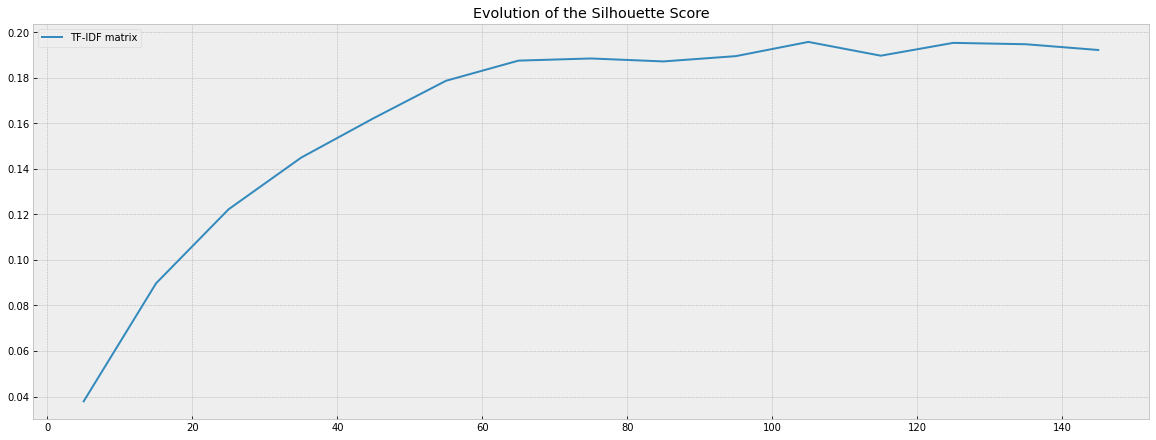

In [ ]:
plt.figure(figsize=(20,16))

plt.subplot(2, 1, 1)
plt.plot(x, score_tfidf, label="TF-IDF matrix")
plt.title("Evolution of the Silhouette Score")
plt.legend()

In [ ]:
d=dict(zip(x,score_tfidf)) #to bring out exact cluster number
d

{5: 0.03788297701373872,
 15: 0.08978164571125703,
 25: 0.12227274120090172,
 35: 0.14494754653432718,
 45: 0.16227789074140234,
 55: 0.1787427597702699,
 65: 0.18759797964704156,
 75: 0.18853963292635711,
 85: 0.1872415412815487,
 95: 0.18957110394584198,
 105: 0.19581114948442155,
 115: 0.18975978217778272,
 125: 0.19539794265687457,
 135: 0.19479702551387945,
 145: 0.19226568087442358}

Text(0.5, 1.0, 'ACP with 105 clusters')

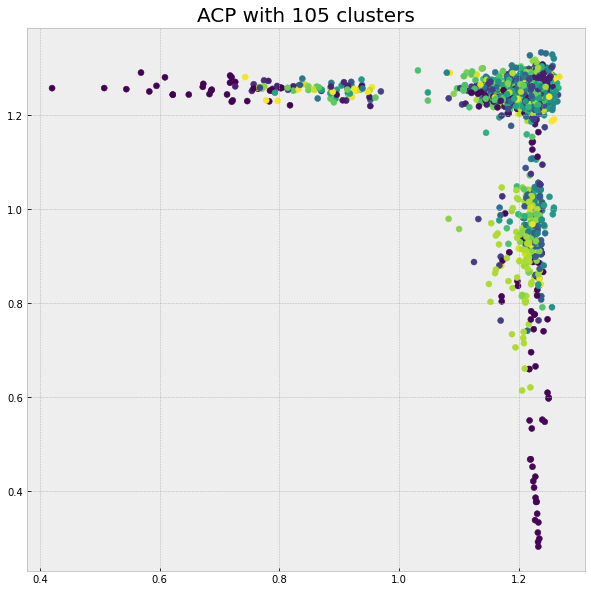

In [ ]:
n_clusters = 105

kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30, random_state=0)
proj = kmeans.fit_transform(TF_IDF_embedded)
clusters = kmeans.predict(TF_IDF_embedded)
plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("ACP with 105 clusters", fontsize="20")

Text(0.5, 1.0, 'Visualization of the clustering with TSNE')

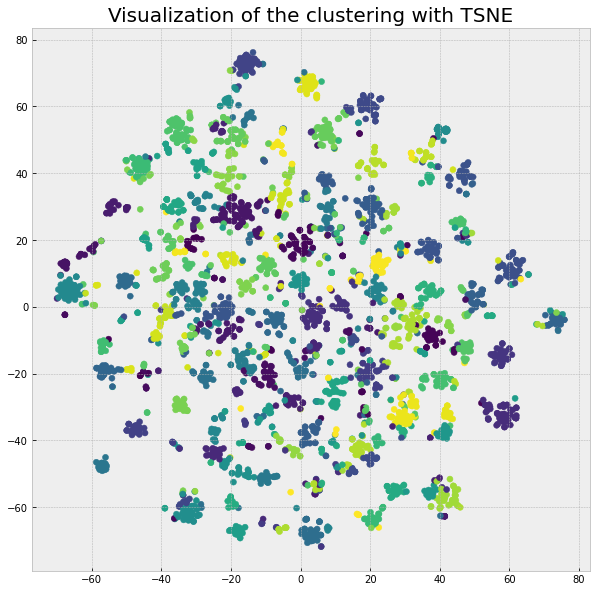

In [ ]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(TF_IDF_embedded)

plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("Visualization of the clustering with TSNE", fontsize="20")

<Figure size 432x288 with 0 Axes>

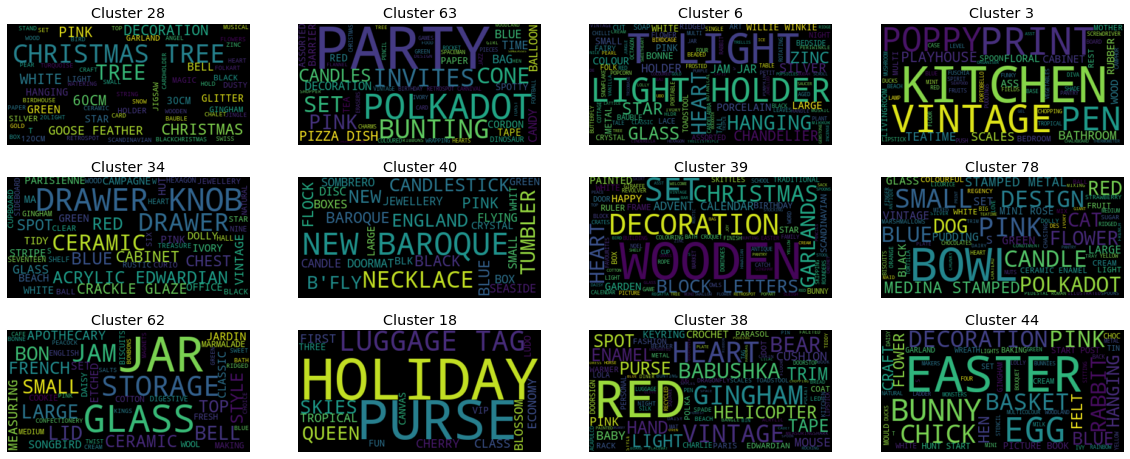

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(20,8))
wc = WordCloud()

for num, cluster in enumerate(random.sample(range(100), 12)) :
    plt.subplot(3, 4, num+1)
    wc.generate(" ".join(X[np.where(clusters==cluster)]))
    plt.imshow(wc, interpolation='bilinear')
    plt.title("Cluster {}".format(cluster))
    plt.axis("off")
plt.figure()

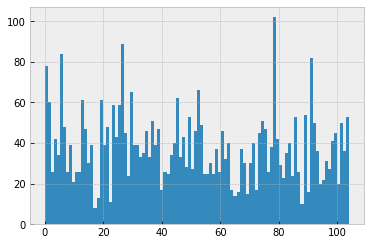

In [ ]:
pd.Series(clusters).hist(bins=100)

In [ ]:
dict_article_to_cluster = {article : cluster for article, cluster in zip(X, clusters)}

Creating Customer Clusters

In [ ]:
cluster = df_cleaned['Description'].apply(lambda x : dict_article_to_cluster[x])
df2 = pd.get_dummies(cluster, prefix="Cluster").mul(df_cleaned["TotalPrice"], 0)
df2 = pd.concat([df_cleaned['InvoiceNo'], df2], axis=1)
df2_grouped = df2.groupby('InvoiceNo').sum()

In [ ]:
custom_aggregation = {}
custom_aggregation["TotalPrice"] = lambda x:x.iloc[0]
custom_aggregation["min_recency"] = lambda x:x.iloc[0]
custom_aggregation["max_recency"] = lambda x:x.iloc[0]
custom_aggregation["frequency"] = lambda x:x.iloc[0]
custom_aggregation["monetary_value"] = lambda x:x.iloc[0]
custom_aggregation["CustomerID"] = lambda x:x.iloc[0]
custom_aggregation["Quantity"] = "sum"
custom_aggregation["Country"] = lambda x:x.iloc[0]


df_grouped = df_cleaned.groupby("InvoiceNo").agg(custom_aggregation)

In [ ]:
df2_grouped_final = pd.concat([df_grouped['CustomerID'], df2_grouped], axis=1).set_index("CustomerID").groupby("CustomerID").sum()
df2_grouped_final = df2_grouped_final.div(df2_grouped_final.sum(axis=1), axis=0)
df2_grouped_final = df2_grouped_final.fillna(0)

In [ ]:
custom_aggregation = {}
custom_aggregation["TotalPrice"] = ['min','max','mean']
custom_aggregation["min_recency"] = lambda x:x.iloc[0]
custom_aggregation["max_recency"] = lambda x:x.iloc[0]
custom_aggregation["frequency"] = lambda x:x.iloc[0]
custom_aggregation["monetary_value"] = lambda x:x.iloc[0]
custom_aggregation["Quantity"] = "sum"
custom_aggregation["Country"] = lambda x:x.iloc[0]

df_grouped_final = df_grouped.groupby("CustomerID").agg(custom_aggregation)

In [ ]:
df_grouped_final.head(5)

TotalPrice                    min_recency max_recency frequency  \
                  min     max       mean    <lambda>    <lambda>  <lambda>   
CustomerID                                                                   
12346            0.00    0.00   0.000000       325.0       325.0         1   
12747           17.70  243.00  62.680909         2.0       369.0        11   
12748            0.00  175.20   9.602524         0.0       373.0       206   
12749           14.85   24.75  18.680000         3.0       213.0         5   
12820           13.20   15.00  14.550000         3.0       326.0         4   

           monetary_value Quantity         Country  
                 <lambda>      sum        <lambda>  
CustomerID                                          
12346                0.00    74215  United Kingdom  
12747             4196.01     1275  United Kingdom  
12748            30064.95    25051  United Kingdom  
12749             3818.20     1470  United Kingdom  
12820              942.34      722  United Kingdom

In [ ]:
df_grouped_final.columns = ["min", "max", "mean", "min_recency", "max_recency", "frequency", "monetary_value", "quantity", "country"]

In [ ]:
df_grouped_final=df_grouped_final.drop('country',axis=1)
df_grouped_final.head(5)

,min,max,mean,min_recency,max_recency,frequency,monetary_value,quantity
CustomerID,,,,,,,,
12346,0.00,0.00,0.000000,325.0,325.0,1,0.00,74215
12747,17.70,243.00,62.680909,2.0,369.0,11,4196.01,1275
12748,0.00,175.20,9.602524,0.0,373.0,206,30064.95,25051
12749,14.85,24.75,18.680000,3.0,213.0,5,3818.20,1470
12820,13.20,15.00,14.550000,3.0,326.0,4,942.34,722


In [ ]:
df2_grouped_final.head(5)

,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,...,Cluster_95,Cluster_96,Cluster_97,Cluster_98,Cluster_99,Cluster_100,Cluster_101,Cluster_102,Cluster_103,Cluster_104
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12747,0.004719,0.000000,0.000000,0.000000,0.000000,0.000000,0.094089,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.374856,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12748,0.006450,0.019786,0.002831,0.005103,0.004253,0.004984,0.041540,0.020592,0.000113,0.013657,...,0.006309,0.006909,0.00254,0.006562,0.006464,0.010805,0.020094,0.012823,0.011803,0.003713
12749,0.000000,0.010529,0.000000,0.003889,0.000000,0.003339,0.008863,0.008459,0.000000,0.028024,...,0.000000,0.000000,0.00000,0.030499,0.029071,0.085629,0.036536,0.026505,0.057750,0.000000
12820,0.010824,0.000000,0.000000,0.000000,0.000000,0.000000,0.100813,0.121421,0.000000,0.015918,...,0.000000,0.000000,0.00000,0.040113,0.000000,0.047435,0.011142,0.000000,0.000000,0.000000


In [ ]:
X1 = df_grouped_final.values
X2 = df2_grouped_final.values

scaler = StandardScaler()                         #experimenting
X1 = scaler.fit_transform(X1)
X_final_std_scale = np.concatenate((X1, X2), axis=1)

In [ ]:
x = list(range(2, 12))
y_std = []
for n_clusters in x:
    print("n_clusters =", n_clusters)
    
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(X_final_std_scale)
    clusters = kmeans.predict(X_final_std_scale)
    silhouette_avg = silhouette_score(X_final_std_scale, clusters)
    y_std.append(silhouette_avg)
    print("The average silhouette_score is :", silhouette_avg, "with Std Scaling")

n_clusters = 2
The average silhouette_score is : 0.8820883401113043 with Std Scaling
n_clusters = 3
The average silhouette_score is : 0.8678492904615551 with Std Scaling
n_clusters = 4
The average silhouette_score is : 0.29283864331754644 with Std Scaling
n_clusters = 5
The average silhouette_score is : 0.39398626042923574 with Std Scaling
n_clusters = 6
The average silhouette_score is : 0.39916287193200006 with Std Scaling
n_clusters = 7
The average silhouette_score is : 0.4006627537730037 with Std Scaling
n_clusters = 8
The average silhouette_score is : 0.4112041579883769 with Std Scaling
n_clusters = 9
The average silhouette_score is : 0.4146591180088038 with Std Scaling
n_clusters = 10
The average silhouette_score is : 0.3990305697965067 with Std Scaling
n_clusters = 11
The average silhouette_score is : 0.3626021246302225 with Std Scaling


In [ ]:
kmeans = KMeans(init='k-means++', n_clusters = 9, n_init=30, random_state=0)  
kmeans.fit(X_final_std_scale)
clusters = kmeans.predict(X_final_std_scale)

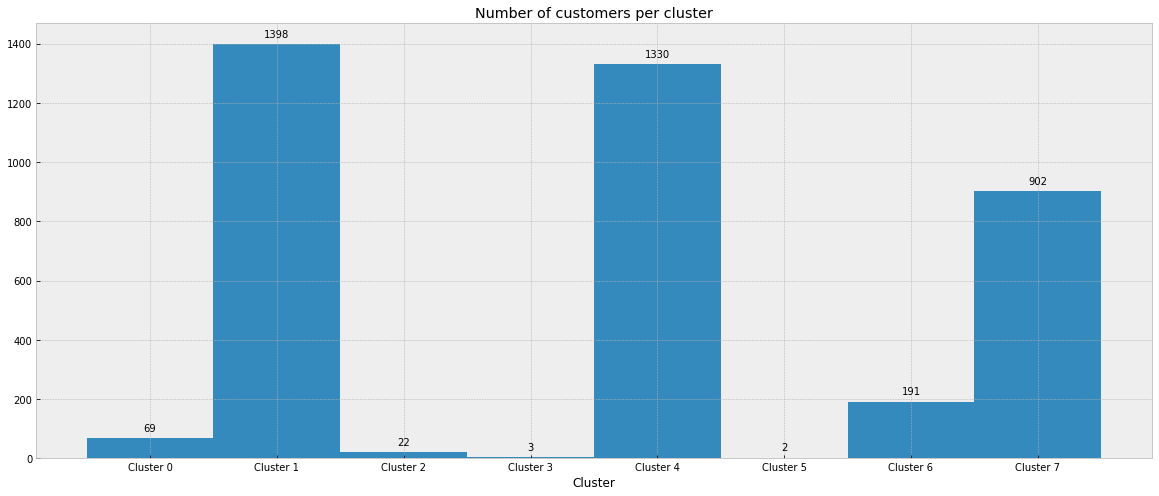

In [ ]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(clusters, bins=8)
plt.xlabel("Cluster")
plt.title("Number of customers per cluster")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Cluster {}".format(x) for x in range(8)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space), 
        textcoords="offset points", 
        ha='center',                
        va=va)

In [ ]:
#Its better we use 7 clusters here as only 2 clusters will be of more generic one

In [ ]:
df_grouped_final["cluster"] = clusters

In [ ]:
final_dataset = pd.concat([df_grouped_final, df2_grouped_final], axis = 1)
final_dataset.tail()

,min,max,mean,min_recency,max_recency,frequency,monetary_value,quantity,cluster,Cluster_0,...,Cluster_95,Cluster_96,Cluster_97,Cluster_98,Cluster_99,Cluster_100,Cluster_101,Cluster_102,Cluster_103,Cluster_104
CustomerID,,,,,,,,,,,,,,,,,,,,,
18280,23.70,23.70,23.700000,277.0,277.0,1,180.60,45,8,0.000000,...,0.000000,0.000000,0.0,0.131229,0.166113,0.098007,0.110188,0.0,0.000000,0.000000
18281,5.04,5.04,5.040000,180.0,180.0,1,80.82,54,8,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
18282,12.75,25.50,19.125000,7.0,126.0,2,176.60,103,4,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.144394,0.000000
18283,0.85,17.70,4.171875,3.0,337.0,16,2039.58,1355,1,0.002476,...,0.000000,0.002035,0.0,0.009046,0.000000,0.016572,0.004486,0.0,0.000000,0.004324
18287,10.20,45.00,26.800000,42.0,201.0,3,1837.28,1586,1,0.000000,...,0.020378,0.020966,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.040821


In [ ]:
final_dataset_V2 = final_dataset.reset_index()

In [ ]:
final_dataset_V2.to_csv("final_dataset_V2.csv",index=False)

Text(0.5, 1.0, 'Visualization of the clustering with TSNE')

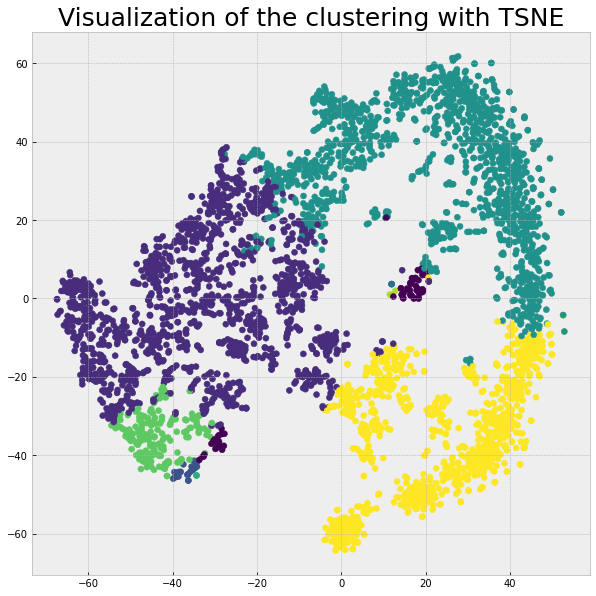

In [ ]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(X_final_std_scale)

plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("Visualization of the clustering with TSNE", fontsize="25")

In [ ]:
#Cluster 0
final_dataset[final_dataset['cluster']==0]

,min,max,mean,min_recency,max_recency,frequency,monetary_value,quantity,cluster,Cluster_0,...,Cluster_95,Cluster_96,Cluster_97,Cluster_98,Cluster_99,Cluster_100,Cluster_101,Cluster_102,Cluster_103,Cluster_104
CustomerID,,,,,,,,,,,,,,,,,,,,,
12823,229.50,535.50,351.90,74.0,296.0,5,1759.50,230,0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.000000,0.0
12830,51.84,587.52,298.32,37.0,171.0,6,6814.64,9848,0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.000000,0.0
12863,323.00,323.00,323.00,52.0,52.0,1,504.20,188,0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.11781,0.00000,0.0,0.709639,0.0
12908,318.00,432.00,375.00,176.0,312.0,2,750.00,1200,0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.000000,0.0
12917,297.00,297.00,297.00,128.0,128.0,1,594.00,120,0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18080,390.00,841.50,615.75,18.0,242.0,2,1231.50,642,0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.000000,0.0
18133,931.50,931.50,931.50,212.0,212.0,1,931.50,1350,0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.000000,0.0
18233,440.00,440.00,440.00,325.0,325.0,1,440.00,4,0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.000000,0.0


In [ ]:
final_dataset[final_dataset['cluster']==0].mean()

min            247.988696
max            617.466087
mean           373.657771
min_recency    103.739130
max_recency    219.971014
                  ...    
Cluster_100      0.008396
Cluster_101      0.015158
Cluster_102      0.002190
Cluster_103      0.023940
Cluster_104      0.003353
Length: 114, dtype: float64

In [ ]:
temp_final_df = final_dataset.reset_index()

In [ ]:
cust0 = list(temp_final_df[temp_final_df['cluster']==0]['CustomerID'])

In [ ]:
cluster0 = df_cleaned[df_cleaned['CustomerID'].isin(cust0)]
cluster0[['Quantity', 'UnitPrice', 'QuantityCanceled', 'TotalPrice', 'frequency', 'min_recency'
         , 'monetary_value']].mean()

Quantity             111.454679
UnitPrice              4.926382
QuantityCanceled       2.183493
TotalPrice           157.983441
frequency             10.826087
min_recency           36.702284
monetary_value      8930.486750
dtype: float64

In [ ]:
cluster0['Description'].value_counts()[:10]

JUMBO BAG RED RETROSPOT         22
BLACK RECORD COVER FRAME        19
REGENCY CAKESTAND 3 TIER        15
RECORD FRAME 7" SINGLE SIZE     14
PARTY BUNTING                   13
EDWARDIAN PARASOL NATURAL       12
LUNCH BOX I LOVE LONDON         12
DOORMAT UNION FLAG              11
EDWARDIAN PARASOL BLACK         11
JUMBO STORAGE BAG SUKI          11
Name: Description, dtype: int64

In [ ]:
custom_aggregation = {}
custom_aggregation["Country"] = lambda x:x.iloc[0]
custom_aggregation["RFMScore"] = lambda x:x.iloc[0]

cluster0_grouped = cluster0.groupby("CustomerID").agg(custom_aggregation)

In [ ]:
cluster0_grouped['RFMScore'].value_counts()          #Normal custmers

111    9
311    7
443    7
343    6
221    5
321    4
432    3
442    2
243    2
344    2
211    2
342    2
332    2
322    1
431    1
232    1
122    1
331    1
231    1
441    1
241    1
242    1
411    1
222    1
433    1
422    1
143    1
133    1
341    1
Name: RFMScore, dtype: int64

In [ ]:
cluster0['Month'].value_counts()

12    192
10    189
11    165
9     141
6     124
8     102
5      84
3      83
7      77
1      76
4      70
2      54
Name: Month, dtype: int64

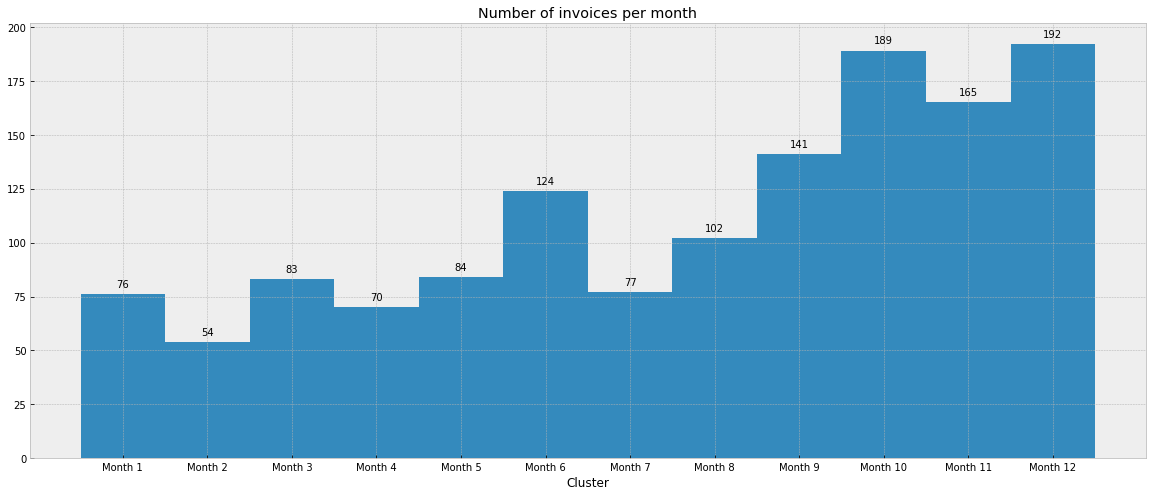

In [ ]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster0['Month'], bins=12)
plt.xlabel("Cluster")
plt.title("Number of invoices per month")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Month {}".format(x) for x in range(1, 13)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center', 
        va=va)

In [ ]:
temp['Year'] = cluster0[cluster0['Month']==12]['InvoiceDate'].map(lambda x: x.year)
temp['Year'].value_counts()

2010.0    38
2011.0    12
Name: Year, dtype: int64

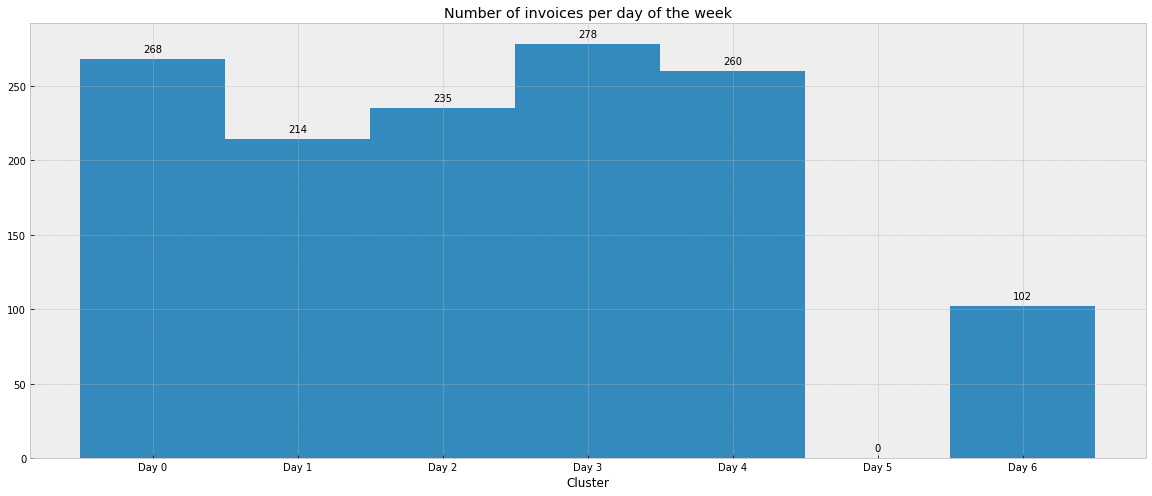

In [ ]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster0['Weekday'], bins=7)
plt.xlabel("Cluster")
plt.title("Number of invoices per day of the week")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Day {}".format(x) for x in range(0, 7)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center', 
        va=va)

In [ ]:
cluster0['Day'].nunique()

31

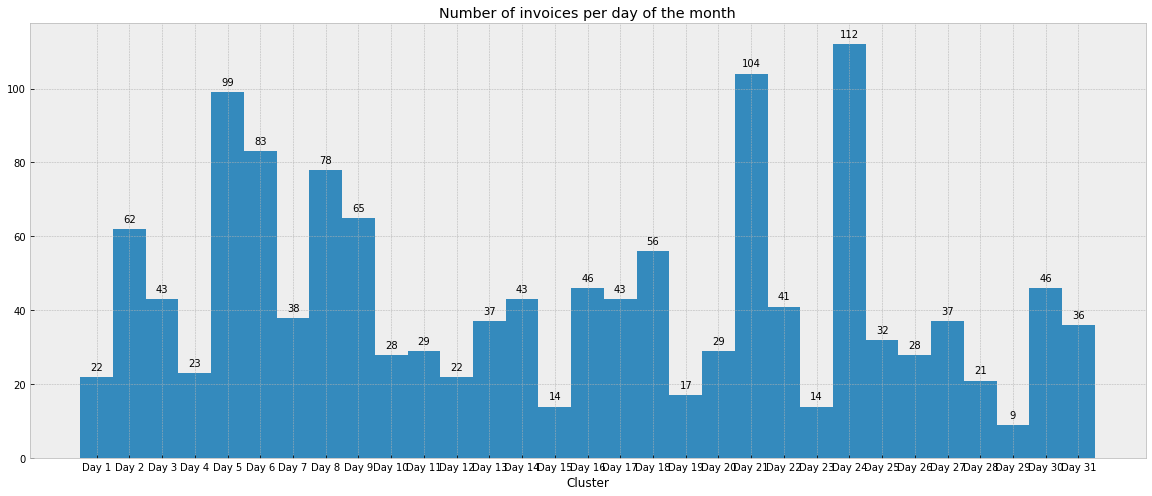

In [ ]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster0['Day'], bins=31)
plt.xlabel("Cluster")
plt.title("Number of invoices per day of the month")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Day {}".format(x) for x in range(1,32)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',
        va=va)

In [ ]:
cluster0['Hour'].nunique()

12

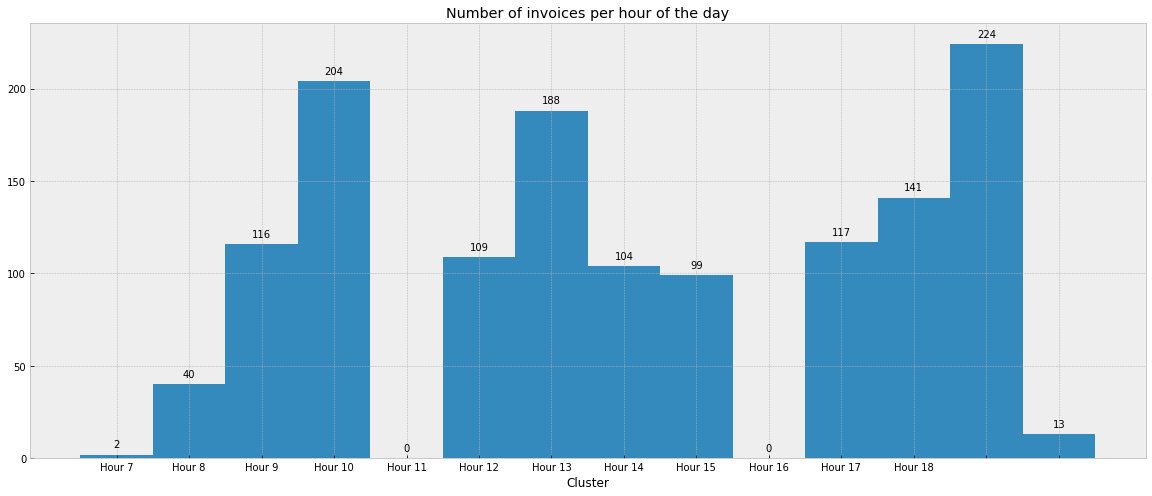

In [ ]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(cluster0['Hour'], bins=14)
plt.xlabel("Cluster")
plt.title("Number of invoices per hour of the day")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Hour {}".format(x) for x in (sorted(cluster0['Hour'].unique()))])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',
        va=va)

In [ ]:
#Cluster 1
final_dataset[final_dataset['cluster']==1]

,min,max,mean,min_recency,max_recency,frequency,monetary_value,quantity,cluster,Cluster_0,...,Cluster_95,Cluster_96,Cluster_97,Cluster_98,Cluster_99,Cluster_100,Cluster_101,Cluster_102,Cluster_103,Cluster_104
CustomerID,,,,,,,,,,,,,,,,,,,,,
12747,17.70,243.00,62.680909,2.0,369.0,11,4196.01,1275,1,0.004719,...,0.000000,0.000000,0.0,0.374856,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12749,14.85,24.75,18.680000,3.0,213.0,5,3818.20,1470,1,0.000000,...,0.000000,0.000000,0.0,0.030499,0.029071,0.085629,0.036536,0.026505,0.057750,0.000000
12820,13.20,15.00,14.550000,3.0,326.0,4,942.34,722,1,0.010824,...,0.000000,0.000000,0.0,0.040113,0.000000,0.047435,0.011142,0.000000,0.000000,0.000000
12826,10.50,20.80,17.071429,2.0,365.0,7,1468.12,1058,1,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.027423,0.000000,0.000000,0.000000
12836,2.50,14.85,7.262500,59.0,311.0,4,2610.36,1062,1,0.000000,...,0.000000,0.000000,0.0,0.058996,0.004310,0.000000,0.005543,0.051709,0.041661,0.001896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18270,19.80,33.20,26.500000,38.0,266.0,2,244.90,101,1,0.000000,...,0.000000,0.000000,0.0,0.102899,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
18272,6.64,18.72,13.053333,2.0,246.0,6,3063.98,2050,1,0.000000,...,0.000000,0.017928,0.0,0.000000,0.000000,0.053346,0.034674,0.000000,0.000000,0.000000
18273,51.00,102.00,68.000000,2.0,257.0,3,204.00,80,1,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
final_dataset[final_dataset['cluster']==1].mean()

min             10.065529
max             54.105308
mean            26.669521
min_recency     41.169528
max_recency    302.144492
                  ...    
Cluster_100      0.012781
Cluster_101      0.024501
Cluster_102      0.010136
Cluster_103      0.017937
Cluster_104      0.006830
Length: 114, dtype: float64

In [ ]:
temp_final_df = final_dataset.reset_index()

In [ ]:
cust1 = list(temp_final_df[temp_final_df['cluster']==1]['CustomerID'])

In [ ]:
cluster1 = df_cleaned[df_cleaned['CustomerID'].isin(cust1)]
cluster1[['Quantity', 'UnitPrice', 'QuantityCanceled', 'TotalPrice', 'frequency', 'min_recency'
         , 'monetary_value']].mean()

Quantity               8.877099
UnitPrice              2.830147
QuantityCanceled       0.101016
TotalPrice            14.460207
frequency              6.629482
min_recency           32.824472
monetary_value      2380.571930
dtype: float64

In [ ]:
custom_aggregation = {}
custom_aggregation["Country"] = lambda x:x.iloc[0]
custom_aggregation["RFMScore"] = lambda x:x.iloc[0]

cluster1_grouped = cluster1.groupby("CustomerID").agg(custom_aggregation)

In [ ]:
cluster1_grouped['RFMScore'].value_counts()           #most loyal customers                                                                                                                                                                                     

111    214
211    128
322    123
222    121
122     98
321     83
221     70
311     52
121     49
323     49
332     46
112     42
333     40
223     40
212     33
233     32
232     24
312     22
123     21
334     20
133     20
234     17
132      9
134      7
324      7
231      6
113      3
124      3
224      3
422      3
213      2
421      2
411      2
331      1
424      1
412      1
313      1
131      1
114      1
414      1
Name: RFMScore, dtype: int64

In [ ]:
cluster1.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice,min_recency,max_recency,frequency,monetary_value,RFMScore,Month,Weekday,Day,Hour
297,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047,United Kingdom,0,54.08,56.0,373.0,9,3105.7,311,12,2,1,8
298,536367,22745,POPPY'S PLAYHOUSE BEDROOM,6,2010-12-01 08:34:00,2.10,13047,United Kingdom,0,12.60,56.0,373.0,9,3105.7,311,12,2,1,8
299,536367,22748,POPPY'S PLAYHOUSE KITCHEN,6,2010-12-01 08:34:00,2.10,13047,United Kingdom,0,12.60,56.0,373.0,9,3105.7,311,12,2,1,8
300,536367,22749,FELTCRAFT PRINCESS CHARLOTTE DOLL,8,2010-12-01 08:34:00,3.75,13047,United Kingdom,0,30.00,56.0,373.0,9,3105.7,311,12,2,1,8
301,536367,22310,IVORY KNITTED MUG COSY,6,2010-12-01 08:34:00,1.65,13047,United Kingdom,0,9.90,56.0,373.0,9,3105.7,311,12,2,1,8


In [ ]:
#cluster 2
final_dataset[final_dataset['cluster']==2]
temp_final_df = final_dataset.reset_index()
cust2 = list(temp_final_df[temp_final_df['cluster']==2]['CustomerID'])
cluster2 = df_cleaned[df_cleaned['CustomerID'].isin(cust2)]
cluster2[['Quantity', 'UnitPrice', 'QuantityCanceled', 'TotalPrice', 'frequency', 'min_recency'
         , 'monetary_value']].mean()
custom_aggregation = {}
custom_aggregation["Country"] = lambda x:x.iloc[0]
custom_aggregation["RFMScore"] = lambda x:x.iloc[0]                             #loyal customers

cluster2_grouped = cluster2.groupby("CustomerID").agg(custom_aggregation)
cluster2_grouped['RFMScore'].value_counts()      
 

111    18
211     2
444     1
134     1
Name: RFMScore, dtype: int64

In [ ]:
#cluster3
final_dataset[final_dataset['cluster']==3]
temp_final_df = final_dataset.reset_index()
cust3 = list(temp_final_df[temp_final_df['cluster']==3]['CustomerID'])
cluster3 = df_cleaned[df_cleaned['CustomerID'].isin(cust3)]
cluster3[['Quantity', 'UnitPrice', 'QuantityCanceled', 'TotalPrice', 'frequency', 'min_recency'
         , 'monetary_value']].mean()
custom_aggregation = {}
custom_aggregation["Country"] = lambda x:x.iloc[0]                                     #worst customers
custom_aggregation["RFMScore"] = lambda x:x.iloc[0]

cluster3_grouped = cluster3.groupby("CustomerID").agg(custom_aggregation)
cluster3_grouped['RFMScore'].value_counts()    

441    2
141    1
Name: RFMScore, dtype: int64

In [ ]:
#cluster4
final_dataset[final_dataset['cluster']==4]
temp_final_df = final_dataset.reset_index()
cust4 = list(temp_final_df[temp_final_df['cluster']==4]['CustomerID'])
cluster4 = df_cleaned[df_cleaned['CustomerID'].isin(cust4)]
cluster4[['Quantity', 'UnitPrice', 'QuantityCanceled', 'TotalPrice', 'frequency', 'min_recency'
         , 'monetary_value']].mean()
custom_aggregation = {}
custom_aggregation["Country"] = lambda x:x.iloc[0]                                       #lost and cheap customers
custom_aggregation["RFMScore"] = lambda x:x.iloc[0]

cluster1_grouped = cluster4.groupby("CustomerID").agg(custom_aggregation)
cluster1_grouped['RFMScore'].value_counts()    

344    186
244    136
343    135
243     81
222     62
122     61
144     54
233     45
133     43
342     38
333     37
232     37
132     36
332     34
121     31
143     29
234     26
111     26
134     24
444     21
123     21
223     19
242     17
322     14
334     14
443     12
323     11
341     10
112     10
221      9
331      6
434      5
124      5
321      5
142      4
224      4
442      4
324      4
212      2
211      2
231      2
311      2
441      1
423      1
131      1
424      1
241      1
432      1
Name: RFMScore, dtype: int64

In [ ]:
#cluster 5
final_dataset[final_dataset['cluster']==5]
temp_final_df = final_dataset.reset_index()
cust5 = list(temp_final_df[temp_final_df['cluster']==5]['CustomerID'])
cluster5 = df_cleaned[df_cleaned['CustomerID'].isin(cust5)]
cluster5[['Quantity', 'UnitPrice', 'QuantityCanceled', 'TotalPrice', 'frequency', 'min_recency'
         , 'monetary_value']].mean()
custom_aggregation = {}
custom_aggregation["Country"] = lambda x:x.iloc[0]
custom_aggregation["RFMScore"] = lambda x:x.iloc[0]                                    #loyal customers

cluster5_grouped = cluster5.groupby("CustomerID").agg(custom_aggregation)
cluster5_grouped['RFMScore'].value_counts()    

111    2
Name: RFMScore, dtype: int64

In [ ]:
#cluster 6
final_dataset[final_dataset['cluster']==6]
temp_final_df = final_dataset.reset_index()
cust6 = list(temp_final_df[temp_final_df['cluster']==6]['CustomerID'])
cluster6 = df_cleaned[df_cleaned['CustomerID'].isin(cust6)]
cluster6[['Quantity', 'UnitPrice', 'QuantityCanceled', 'TotalPrice', 'frequency', 'min_recency'  
         , 'monetary_value']].mean()
custom_aggregation = {}
custom_aggregation["Country"] = lambda x:x.iloc[0]
custom_aggregation["RFMScore"] = lambda x:x.iloc[0]
                                                                                              #Loyal customers
cluster6_grouped = cluster6.groupby("CustomerID").agg(custom_aggregation)
cluster6_grouped['RFMScore'].value_counts()    

111    153
211     31
311      4
411      2
212      1
Name: RFMScore, dtype: int64

In [ ]:
#cluster 7
final_dataset[final_dataset['cluster']==7]
temp_final_df = final_dataset.reset_index()
cust7 = list(temp_final_df[temp_final_df['cluster']==7]['CustomerID'])
cluster7 = df_cleaned[df_cleaned['CustomerID'].isin(cust7)]
cluster7[['Quantity', 'UnitPrice', 'QuantityCanceled', 'TotalPrice', 'frequency', 'min_recency'
         , 'monetary_value']].mean()
custom_aggregation = {}
custom_aggregation["Country"] = lambda x:x.iloc[0]                                                #normal Customers
custom_aggregation["RFMScore"] = lambda x:x.iloc[0]

cluster7_grouped = cluster7.groupby("CustomerID").agg(custom_aggregation)
cluster7_grouped['RFMScore'].value_counts()    

121    2
131    1
421    1
Name: RFMScore, dtype: int64

In [ ]:
#Cluster 8
final_dataset[final_dataset['cluster']==8]
temp_final_df = final_dataset.reset_index()
cust8 = list(temp_final_df[temp_final_df['cluster']==8]['CustomerID'])
cluster8 = df_cleaned[df_cleaned['CustomerID'].isin(cust8)]
cluster8[['Quantity', 'UnitPrice', 'QuantityCanceled', 'TotalPrice', 'frequency', 'min_recency'
         , 'monetary_value']].mean()
custom_aggregation = {}
custom_aggregation["Country"] = lambda x:x.iloc[0]
custom_aggregation["RFMScore"] = lambda x:x.iloc[0]                                                 #lost cheap customers

cluster8_grouped = cluster8.groupby("CustomerID").agg(custom_aggregation)
cluster8_grouped['RFMScore'].value_counts()    

444    375
443    191
433     92
434     50
432     48
422     41
423     34
442     27
424     10
421      8
411      7
431      5
412      4
413      2
441      2
332      1
334      1
Name: RFMScore, dtype: int64

In [ ]:
cluster1['Description'].nunique()

3578

In [ ]:
from collections import Counter as c 
d1=c(cluster1['Description'])
tv1=[i for i in d1.values()]

In [ ]:
v=[i for i in d1.values()]
v.sort()
cx=v[-10:]

In [ ]:
for i in cx:
  px=v.index(i) #top 10 products in cluster1
  print(list(d1.keys())[px],i)

GREEN PAIR HEART HAIR SLIDES 463
PEARL AND CHERRY QUARTZ BRACLET 490
KNITTED RABBIT DOLL  496
LAVENDER SCENT CAKE CANDLE 522
PURPLE/BLUE CERAMIC CANDLE HOLDER 567
BLUE/YELLOW CERAMIC CANDLE HOLDER 614
GREEN/BLUE CERAMIC CANDLE HOLDER 631
LIGHT PINK FLOCK GLASS CANDLEHOLDER 650
CUTE RABBIT CEATURE SCREEN  677
CUTE BIRD CEATURE SCREEN 1008
